# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В данном проекте тестируется модель,которая умеет классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

По заданию требуется модель со значением метрики качества *F1* не меньше 0.75.

План работ следующий:
 - открыть,подготовить и разделить датасет
 - произвести векторизацию текстов
 - обучить модели на векторизированных текстах
 - лучшей модели предоставить тестовый датасет

## Подготовка

### Подключение библиотек

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os 
import pandas as pd
import re 
import time 
import numpy as np
import nltk
import lightgbm as lgb

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

### Чтение файла данных и его обзор

Для анализа предоставлен обучающий датасет.

In [3]:
#читаем файл с сайта или с компа 
pth1 = '/datasets/toxic_comments.csv'
pth2 = '/home/dmitrii/Документы/ucheba/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Файл не прочитался')

In [4]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


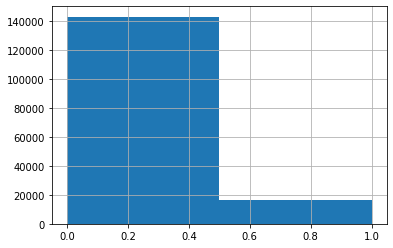

In [6]:
df['toxic'].hist(bins=2);

Исследование датасета показывает, что в данных отсутствуют пропуски. Количество данных должно быть достаточно для анализа. На гистрограмме видно, что данные имеют несбалансированное распределение. Токсичных комментариев сильно меньше нормальных. При построении моделей это будет устранено опцией решателя balance. 

### Подготовка файла

Для анализа колонка 'Unnamed: 0' не несет смысла, поэтому удалим её. Так же для ограничения размерности пространства ограничим размер анализируемых текстов 

In [7]:
df = df.drop('Unnamed: 0',axis=1)

In [8]:
#очистка от лиших символов
pattern = r'[^a-zA-Z ]'
df['text'] = df['text'].apply(lambda x: re.sub(pattern, ' ', x))
#ограничиваем размер символов
df['text'] = df['text'].str.slice(stop = 2000)
df.head(10)

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He matches this background colour I m s...,0
2,Hey man I m really not trying to edit war It...,0
3,More I can t make any real suggestions on im...,0
4,You sir are my hero Any chance you remember...,0
5,Congratulations from me as well use the to...,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word nonsense was offensive to ...,0
9,alignment on this subject and which are contra...,0


## Подготовка к расчету

### Разделение выборки

Разделим выборку на 3 части - тренировучню, валидационную, тестовую. Т.к. данные сильно несбалансированные, то деление будет просходить с активированной опцией stratify.

In [9]:
train, var = train_test_split(df, test_size=0.2,stratify=df['toxic'], random_state=12345)

#train
features_train = train['text']
target_train = train['toxic']

valid, test = train_test_split(var, test_size=0.5,stratify=var['toxic'], random_state=12345)

#valid 
features_valid = valid['text']
target_valid = valid['toxic']

#test
features_test = test['text']
target_test = test['toxic']

### Векторизация слов

Для возможности провести анализ текстов необходимо произвести обработку текстов для подготовки к численному анализу. В первую очередь тексты очищаются от лишних слов,не несущих смысловую нагрузку. 

In [10]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Произведем векторизацию текстов

In [11]:
tf_idf = count_tf_idf.fit(features_train)
features_train = tf_idf.transform(features_train)
features_valid = tf_idf.transform(features_valid)
features_test = tf_idf.transform(features_test)

## Построение моделей

### Logistic regression

Логистическая регрессия подходит для проведения бинарной классификации. Для устранения несбалансированности установлен гиперпараметр весов классов с автоматической коррекцией. 

In [12]:
#разные решатели
solver = ['sag','lbfgs','liblinear']
#массив для разных моделей
models = []

for item in solver:
    start = time.time() 
    model_log = LogisticRegression(max_iter=400, 
                                   class_weight='balanced',
                                   random_state=12345,
                                   solver = item )
    model_log.fit(features_train, target_train)
    predicted = model_log.predict(features_valid)
    f1 = f1_score(target_valid,predicted)
    total_time = time.time()-start
    print( 'Метрика F1:', f1,'| Время', total_time, '| Solver - ',item  ) 
    models.append(model_log)

Метрика F1: 0.7677383592017738 | Время 5.467674255371094 | Solver -  sag
Метрика F1: 0.7677383592017738 | Время 78.066734790802 | Solver -  lbfgs
Метрика F1: 0.7677383592017738 | Время 14.310633420944214 | Solver -  liblinear


Анализируя результаты работы логистической с разными гиперпараметрами решателя видно, что наиболее быстрый решатель - liblinear. Результаты метрики f1 всех решателей одинаковы, но т.к. liblinear справился в разы быстрее, то имеет смысл использовать его.  

Результат превышает минимально требуемый по заданию. 

### LightGBM

В качестве альтернативы рассмотрим классификатор LightGBM. Так же установим параметры для сбалансирования весов классов.

In [13]:
%%time
lgbm = lgb.LGBMClassifier(class_weight='balanced',
                                   random_state=12345)
lgbm.fit(features_train, target_train);

CPU times: user 4min 3s, sys: 0 ns, total: 4min 3s
Wall time: 4min 5s


LGBMClassifier(class_weight='balanced', random_state=12345)

In [14]:
preds_class = lgbm.predict(features_valid)

In [15]:
print('Метрика F1:', f1_score(target_valid,preds_class) )

Метрика F1: 0.7359454855195912


## Тестирование лучшей модели

Наилучшие результаты показала модель логистической регрессии. Протестируем её на тестовом датафрейме. 

In [16]:
predicted_test = models[2].predict(features_test)
print('Метрика F1:', f1_score(target_test,predicted_test) )

Метрика F1: 0.7531266992930942


## Вывод

В ходе работы обработан датафрейм с целью построения модели. Текст очищен и преобразован в векторную форму. С целью уменьшения размерности длина твитов ограничена 2000 букв. 

В результате построенных моделей логистической регрессии и lightGBM видно, что хорошие результаты показала модель логистической регрессии. На тестовой выборке она выдала результаты с метрикой F1 выше минимально требуемых 0,75. Таким образом данная модель подходит для анализа и классификации тональности. 